In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data Loading and Preprocessing

In [3]:
data = None
if not os.path.exists('./BTCUSDT_DB.csv'):
    data = pd.read_csv("BTCUSDT_1m.csv")
    data = get_dollar_bars(data)
    data.to_csv('./BTCUSDT_DB.csv', sep=',')
else:
    data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

ma1, ma2 = 5, 10
handler.data = ma_crossover_labelling(handler.data, ma1, ma2)
handler.data.rename({'Label': 'Crossover'}, axis=1, inplace=True)
dummies = pd.get_dummies(handler.data['Crossover'], prefix='Crossover') * 1
handler.data.drop('Crossover', axis=1, inplace=True)
handler.data = pd.concat([handler.data, dummies], axis=1)
handler.data = triple_barrier_labelling(handler.data)

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.TICK_DENSITY])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.PERC_RET,
                              Indicators.TICK_DENSITY])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[f'MA{ma1} Var'], predict_data[f'MA{ma2} Var'] = handler.data[f'MA{ma1} Var'], handler.data[f'MA{ma2} Var']
predict_data[dummies.columns] = handler.data[dummies.columns]
predict_data[f'MA{ma1} UP'], predict_data[f'MA{ma2} UP'] = (handler.data[f'MA{ma1}'] > handler.data[f'MA{ma2}']) * 1, (handler.data[f'MA{ma1}'] < handler.data[f'MA{ma2}']) * 1
predict_data.reset_index(drop=True, inplace=True)

Could not add indicator OBV
Error message 'Volume'
Ignoring indicator OBV. Reason: Not found in the list of indicators


C:\Users\user\AppData\Local\Temp\ipykernel_9264\3813629219.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\user\AppData\Local\Temp\ipykernel_9264\3813629219.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[f'MA{ma1} Var'], predict_data[f'MA{ma2} Var'] = handler.data[f'MA{ma1} Var'], handler.data[f'MA{ma2} Var']
C:\Users\user\AppData\Local\Temp\ipykernel_9264\3813629219.py:37: SettingWithCopyWarning: 
A value is trying to be set on

In [4]:
handler.data

,Unnamed: 0,Unix,Open,High,Low,Close,NTrades,MA5,MA10,MA5 Var,MA10 Var,Crossover_-1,Crossover_0,Crossover_1,Label,Index,RSI,MACD,MACD_H,ADX14,+DM,-DM,TICK_DENSITY,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,PERC_RET,TICK_DENSITY Var
34,34,1513428720000,17850.00,19539.00,17850.00,19280.99,56807.0,17450.364,16787.578,0.039638,0.017862,1,0,0,0.0,35.0,80.348473,2533.945639,-166.062307,44.592596,33.427218,10.706813,53268.0,0.048401,0.029123,-0.405401,0.015614,-0.081688,0.192699,0.080168,0.140838
35,35,1513501980000,19280.99,19798.68,18523.00,19109.98,49453.0,18064.398,17088.576,0.035187,0.017930,1,0,0,-1.0,36.0,78.739404,2547.607403,-121.920434,45.332567,32.612835,10.039731,59832.0,-0.020026,0.005391,-0.265815,0.016594,-0.062304,-0.024363,-0.008869,0.123226
36,36,1513550040000,19109.98,19449.48,17029.98,18835.02,44788.0,18585.202,17340.275,0.028830,0.014729,1,0,0,0.0,37.0,76.100538,2507.344371,-129.746773,43.919360,28.931099,15.872654,61392.0,-0.033514,-0.015804,0.064192,-0.031174,0.580984,-0.112892,-0.014388,0.026073
37,37,1513582380000,18835.02,19300.00,18021.98,18560.06,47706.0,18727.210,17544.881,0.007641,0.011799,1,0,0,0.0,38.0,73.449601,2425.291404,-169.439792,42.649695,27.185297,14.914843,57744.0,-0.034835,-0.032725,0.305927,-0.028909,-0.060343,-0.060343,-0.014598,-0.059421
38,38,1513633980000,18560.56,18950.00,16464.10,17169.90,49919.0,18591.190,17688.114,-0.007263,0.008164,1,0,0,0.0,39.0,61.739634,2222.470288,-297.808726,39.773219,24.134590,20.273729,58344.0,-0.159429,-0.083628,0.757608,-0.067444,0.359299,-0.112219,-0.074901,0.010391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35408,35408,1685267280000,27149.99,27344.23,27100.02,27142.07,88940.0,27152.234,26949.742,0.002310,0.001424,1,0,0,1.0,35410.0,67.069947,162.727474,55.834389,23.632173,28.779883,12.047856,11148.0,-0.007022,0.040183,-0.120811,0.059854,-0.088035,0.037811,-0.000292,-0.070070
35409,35409,1685279100000,27142.07,27344.00,27134.75,27236.47,82731.0,27184.688,27007.552,0.001195,0.002145,1,0,0,1.0,35413.0,69.789378,173.328669,53.148467,24.871447,26.617614,11.142686,9012.0,0.040546,0.065147,-0.048105,0.052440,-0.075131,-0.075131,0.003478,-0.191604
35410,35410,1685290800000,27236.47,27745.45,27212.91,27692.89,97964.0,27284.358,27101.374,0.003666,0.003474,1,0,0,1.0,35415.0,78.873609,216.068766,76.710851,27.250313,34.944744,9.240011,10812.0,0.130166,0.246584,0.443331,0.095646,-0.170755,0.312843,0.016758,0.199734
35411,35411,1685298180000,27692.90,27746.33,27535.29,27570.49,64338.0,27358.384,27182.154,0.002713,0.002981,1,0,0,1.0,35413.0,72.571365,237.328172,78.376206,29.461313,32.599480,8.612392,10368.0,-0.079903,0.098392,0.021710,0.081137,-0.067924,-0.067113,-0.004420,-0.041065


In [5]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,TICK_DENSITY Var,PERC_RET,Target,MA5 Var,MA10 Var,Crossover_-1,Crossover_0,Crossover_1,MA5 UP,MA10 UP
0,1513428720000,0.048401,0.029123,-0.405401,0.015614,-0.081688,0.192699,0.140838,0.080168,0.0,0.039638,0.017862,1,0,0,1,0
1,1513501980000,-0.020026,0.005391,-0.265815,0.016594,-0.062304,-0.024363,0.123226,-0.008869,-1.0,0.035187,0.017930,1,0,0,1,0
2,1513550040000,-0.033514,-0.015804,0.064192,-0.031174,0.580984,-0.112892,0.026073,-0.014388,0.0,0.028830,0.014729,1,0,0,1,0
3,1513582380000,-0.034835,-0.032725,0.305927,-0.028909,-0.060343,-0.060343,-0.059421,-0.014598,0.0,0.007641,0.011799,1,0,0,1,0
4,1513633980000,-0.159429,-0.083628,0.757608,-0.067444,0.359299,-0.112219,0.010391,-0.074901,0.0,-0.007263,0.008164,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35374,1685267280000,-0.007022,0.040183,-0.120811,0.059854,-0.088035,0.037811,-0.070070,-0.000292,1.0,0.002310,0.001424,1,0,0,1,0
35375,1685279100000,0.040546,0.065147,-0.048105,0.052440,-0.075131,-0.075131,-0.191604,0.003478,1.0,0.001195,0.002145,1,0,0,1,0
35376,1685290800000,0.130166,0.246584,0.443331,0.095646,-0.170755,0.312843,0.199734,0.016758,1.0,0.003666,0.003474,1,0,0,1,0
35377,1685298180000,-0.079903,0.098392,0.021710,0.081137,-0.067924,-0.067113,-0.041065,-0.004420,1.0,0.002713,0.002981,1,0,0,1,0


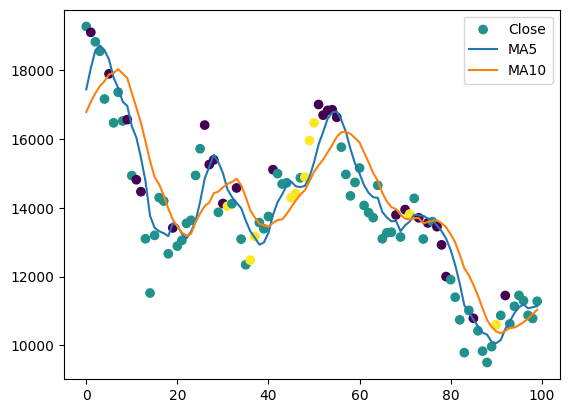

In [6]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'MA{ma1}'][0:100], label=f"MA{ma1}")
plt.plot(range(100), handler.data[f'MA{ma2}'][0:100], label=f"MA{ma2}")
plt.legend()
plt.show()


### Creating Torch Dataset

In [7]:
seq_length = 15
dataset = TSDataset(predict_data, seq_length)

#### Regular model dataset

In [8]:
train_indices = range(0, round(0.7 * len(dataset)), int(seq_length / 3))
val_indices = range(round(0.7 * len(dataset)), len(dataset) - seq_length)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling

#### Meta Labelling model dataset

In [9]:
meta_train_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)))
meta_val_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)

meta_train_set = torch.utils.data.Subset(dataset, meta_train_indices)
meta_val_set = torch.utils.data.Subset(dataset, meta_val_indices)

In [10]:
meta_data = predict_data.loc[list(meta_train_indices) + list(meta_val_indices) + list(range(len(dataset) - seq_length, len(dataset)))]

#### Training set label distribution

In [11]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

-1.0    3258
 1.0    1505
 0.0     188
Name: Target, dtype: int64

[0.6580488790143405, 0.03797212684306201, 0.30397899414259744]

#### Validation set label distribution

In [12]:
val_label_distribution = (predict_data.loc[val_set.indices, 'Target'].value_counts() / predict_data.loc[val_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[val_set.indices, 'Target'].value_counts())
val_label_distribution

-1.0    5448
 0.0    2872
 1.0    2274
Name: Target, dtype: int64

[0.5142533509533699, 0.27109684727204075, 0.2146498017745894]

### Creating Sampler

In [13]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[1.519643953345611, 26.335106382978722, 3.289700996677741]


### Creating LSTM Model

In [14]:
input_size = dataset.size
hidden_size = 100
batch_size = 64
num_layers = 1
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size).to(device)

### Training Model

In [15]:
weights = torch.Tensor(label_distribution).to(device)
train_lstm(lstm_model, train_set, val_set, 30, 0.0001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None)

Epoch: 1/30 -- [1794/4951 (100.0%)]	Loss: 1.0983661183944116	Accuracy: 0.345	Time taken: 5.453125	Validation Loss: 1.0981082916259766 || Validation Accuracy: 0.330
Epoch: 2/30 -- [1794/4951 (100.0%)]	Loss: 1.0979503897520213	Accuracy: 0.383	Time taken: 5.5	Validation Loss: 1.0975319147109985 || Validation Accuracy: 0.419
Epoch: 3/30 -- [1794/4951 (100.0%)]	Loss: 1.0973635025513477	Accuracy: 0.397	Time taken: 5.875	Validation Loss: 1.0972744226455688 || Validation Accuracy: 0.407
Epoch: 4/30 -- [1794/4951 (100.0%)]	Loss: 1.0959641979290888	Accuracy: 0.417	Time taken: 5.84375	Validation Loss: 1.0855122804641724 || Validation Accuracy: 0.510
Epoch: 5/30 -- [1794/4951 (100.0%)]	Loss: 1.082784985884642	Accuracy: 0.435	Time taken: 4.9375	Validation Loss: 1.0301580429077148 || Validation Accuracy: 0.568
Epoch: 6/30 -- [1794/4951 (100.0%)]	Loss: 1.053142895301183	Accuracy: 0.503	Time taken: 5.484375	Validation Loss: 0.9827602505683899 || Validation Accuracy: 0.582
Epoch: 7/30 -- [1794/4951 (10

([1.0983661183944116,
  1.0979503897520213,
  1.0973635025513477,
  1.0959641979290888,
  1.082784985884642,
  1.053142895301183,
  1.0238628471509004,
  0.9948797134252695,
  0.9823485605227642,
  0.9867726686673287,
  0.9743551657750056,
  0.9731208368753775,
  0.9690366899355863,
  0.9726670789412963,
  0.9560275498108987,
  0.9556114780597198,
  0.9515996544789045,
  0.9543254719330714,
  0.9415883253782223,
  0.9430294869801937,
  0.9455494941809238,
  0.9337458442419003,
  0.9357609038169568,
  0.9268753207646884,
  0.9323852001092373,
  0.9373049774231055,
  0.925573488076528,
  0.9321099298122602,
  0.9183031977751316,
  0.9221762128365345],
 [0.3445768531609776,
  0.38335689759644515,
  0.3972934760654413,
  0.41668349828317514,
  0.4354675823066047,
  0.5025247424762674,
  0.5312058170066654,
  0.5453443748737629,
  0.5489800040395879,
  0.5439305190870531,
  0.5655423146839023,
  0.5675621086649162,
  0.5734195112098566,
  0.5625126237123813,
  0.5889719248636639,
  0.588164

### Creating meta labels

In [16]:
meta_train_outputs, meta_train_targets = eval_lstm(lstm_model, meta_train_set, len(meta_train_set.dataset), num_layers, hidden_size, device)
meta_train_outputs, meta_train_targets = meta_train_outputs.cpu(), meta_train_targets.cpu()

Accuracy : 0.5252368160610773 || Loss : 1.0026965141296387
Confusion matrix : 
[[2267.  698.  568.]
 [ 675.  492. 1043.]
 [ 170.  204.  956.]]


In [17]:
meta_val_outputs, meta_val_targets = eval_lstm(lstm_model, meta_val_set, len(meta_val_set.dataset), num_layers, hidden_size, device)
meta_val_outputs, meta_val_targets = meta_val_outputs.cpu(), meta_val_targets.cpu()

Accuracy : 0.61005396194263 || Loss : 0.9266444444656372
Confusion matrix : 
[[1264.  372.  274.]
 [ 201.  147.  305.]
 [  70.  151.  737.]]


In [18]:
meta_target = (torch.argmax(torch.cat((meta_train_outputs, meta_val_outputs), dim=0), dim=-1).numpy() == meta_data['Target'].shift(-seq_length)[list(meta_train_indices) + list(meta_val_indices)] + 1) * 1

In [19]:
meta_output = torch.argmax(torch.cat((meta_train_outputs, meta_val_outputs), dim=0), dim=-1).detach() - 1
meta_output = pd.Series(meta_output.numpy())
meta_output.index = meta_target.index
meta_output

24755    1
24756    1
24757    1
24758    1
24759    1
        ..
35344    1
35345    1
35346    1
35347    1
35348    1
Length: 10594, dtype: int64

### Assembling meta dataset from meta labels

In [20]:
meta_data = predict_data.loc[list(meta_train_indices) + list(meta_val_indices)]
meta_data['Target'] = pd.Series(meta_target).shift(seq_length)
meta_data['Output'] = meta_output.shift(seq_length)
# meta_data.dropna(axis=0, inplace=True)

In [21]:
meta_dataset = TSDataset(meta_data.drop('Output', axis=1).reset_index(drop=True), seq_length)

In [22]:
meta_train_set = torch.utils.data.Subset(meta_dataset, range(round(0.7 * len(meta_dataset))))
meta_val_set = torch.utils.data.Subset(meta_dataset, range(round(0.7 * len(meta_dataset)), len(meta_dataset) - seq_length))

In [23]:
meta_data['Target'].dropna().value_counts()

1.0    5848
0.0    4731
Name: Target, dtype: int64

### Creating and training Meta model

In [24]:
meta_output_size = meta_data['Target'].dropna().unique().size
meta_output_size = 1 if meta_output_size == 2 else meta_output_size
meta_lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, meta_output_size).to(device)

In [26]:
train_lstm(meta_lstm_model, meta_train_set, meta_val_set, 30, 0.0001,
           batch_size, num_layers, hidden_size, device, None, class_weights=None)

Epoch: 1/30 -- [5220/7405 (100.0%)]	Loss: 0.5561489894472319	Accuracy: 0.707	Time taken: 7.5	Validation Loss: 0.5810670256614685 || Validation Accuracy: 0.681
Epoch: 2/30 -- [5220/7405 (100.0%)]	Loss: 0.5529508076865097	Accuracy: 0.707	Time taken: 7.875	Validation Loss: 0.5890519022941589 || Validation Accuracy: 0.671
Epoch: 3/30 -- [5220/7405 (100.0%)]	Loss: 0.5533111747996561	Accuracy: 0.709	Time taken: 7.34375	Validation Loss: 0.5987332463264465 || Validation Accuracy: 0.661
Epoch: 4/30 -- [5220/7405 (100.0%)]	Loss: 0.5505649814831799	Accuracy: 0.713	Time taken: 7.296875	Validation Loss: 0.5836167931556702 || Validation Accuracy: 0.682
Epoch: 5/30 -- [5220/7405 (100.0%)]	Loss: 0.5488783696602131	Accuracy: 0.713	Time taken: 7.28125	Validation Loss: 0.6057993769645691 || Validation Accuracy: 0.656
Epoch: 6/30 -- [5220/7405 (100.0%)]	Loss: 0.5504660015476162	Accuracy: 0.711	Time taken: 6.890625	Validation Loss: 0.5929675698280334 || Validation Accuracy: 0.681
Epoch: 7/30 -- [5220/7405 

([0.5561489894472319,
  0.5529508076865097,
  0.5533111747996561,
  0.5505649814831799,
  0.5488783696602131,
  0.5504660015476162,
  0.550937734030444,
  0.5462768732987601,
  0.5462623760104179,
  0.5453966046715605,
  0.5426864852679187,
  0.5425926187428934,
  0.5404306778620029,
  0.5403735856043881,
  0.5396024944453404,
  0.5391998943583719,
  0.538857221346477,
  0.534841992217919,
  0.5333452712872933,
  0.5331707355277292,
  0.5307362213216978,
  0.5293340981006622,
  0.5275413856424135,
  0.5277904423660246,
  0.5252875950315903,
  0.5234238782833363,
  0.5235789636599606,
  0.5226358098202738,
  0.5212737208810346,
  0.5175330173866503],
 [0.7066846725185685,
  0.7072248480756246,
  0.7092505064145848,
  0.712896691424713,
  0.712896691424713,
  0.7110060769750168,
  0.7100607697501689,
  0.7133018230925051,
  0.7134368669817691,
  0.7164078325455773,
  0.7160027008777853,
  0.7173531397704254,
  0.7197839297771775,
  0.7192437542201215,
  0.7204591492234976,
  0.7205941931